In [8]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
""" %matplotlib inline
%config InlineBackend.figure_format = 'retina'"""

import warnings

from tqdm.notebook import tqdm
from multiprocessing import Pool, cpu_count
from functools import partial

import numpy as np
import pandas as pd
import scipy.stats as ss
import os
import pickle

from scipy.optimize import curve_fit

import statsmodels.formula.api as smf

from neurodsp.spectral import compute_spectrum
from fooof import FOOOF

""" import seaborn as sns
sns.set_style('whitegrid')"""

import matplotlib.pyplot as plt
#from matplotlib import cm, rc

from collections import Counter
import seaborn as sns

### Read pickle files  - rat single knee results after removing outliers 

In [10]:
#loop through pickle results in folder

pickle_dir_taus = '/Users/blancamartin/Desktop/Voytek_Lab/timescales/rat_pickle_files/rats_singleknee_timescales.pickle'
pickle_dir_divs  = '/Users/blancamartin/Desktop/Voytek_Lab/timescales/rat_pickle_files/rats_singleknee_divs.pickle'
pickle_dir_cultures = '/Users/blancamartin/Desktop/Voytek_Lab/timescales/rat_pickle_files/rats_singleknee_cultures.pickle'


In [34]:
#load pickle files
with open(pickle_dir_taus, 'rb') as f:
    rat_taus = pickle.load(f)
    
with open(pickle_dir_divs, 'rb') as f:
    rat_divs = pickle.load(f)

with open(pickle_dir_cultures, 'rb') as f:
    rat_cults = pickle.load(f)

Text(0.5, 0, 'DIVS')

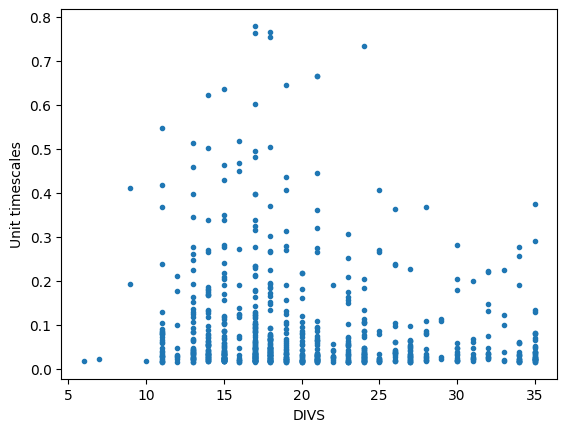

In [35]:
plt.plot(rat_divs, rat_taus, '.')
plt.ylabel("Unit timescales")
plt.xlabel("DIVS")

##### It looks like the early divs have very few timepoints after outlier removal

In [36]:

# Assuming you have 'divs' as your numpy array
unique_divs, divs_counts = np.unique(rat_divs, return_counts=True)

# Now, 'unique_divs' contains unique values in 'divs', and 'divs_counts' contains their respective counts
for div, count in zip(unique_divs, divs_counts):
    print(f"div: {div}, Count: {count}")

div: 6, Count: 1
div: 7, Count: 1
div: 9, Count: 2
div: 10, Count: 1
div: 11, Count: 29
div: 12, Count: 9
div: 13, Count: 44
div: 14, Count: 54
div: 15, Count: 70
div: 16, Count: 19
div: 17, Count: 92
div: 18, Count: 81
div: 19, Count: 40
div: 20, Count: 32
div: 21, Count: 42
div: 22, Count: 10
div: 23, Count: 30
div: 24, Count: 42
div: 25, Count: 14
div: 26, Count: 18
div: 27, Count: 26
div: 28, Count: 13
div: 29, Count: 4
div: 30, Count: 14
div: 31, Count: 10
div: 32, Count: 13
div: 33, Count: 6
div: 34, Count: 20
div: 35, Count: 33


#### Remove divs before DIV 11 - not enough datapoints

In [37]:

# Assuming you have 'divs' and 'taus' as your numpy arrays
threshold = 11  # Set your desired threshold value

# Create a mask to filter data points where divs are greater than or equal to the threshold
mask = (rat_divs >= threshold)

# Apply the mask to both 'divs' and 'taus' arrays
filtered_divs = rat_divs[mask]
filtered_taus = rat_taus[mask]
filtered_cults = rat_cults[mask]

Text(0.5, 0, 'DIVS')

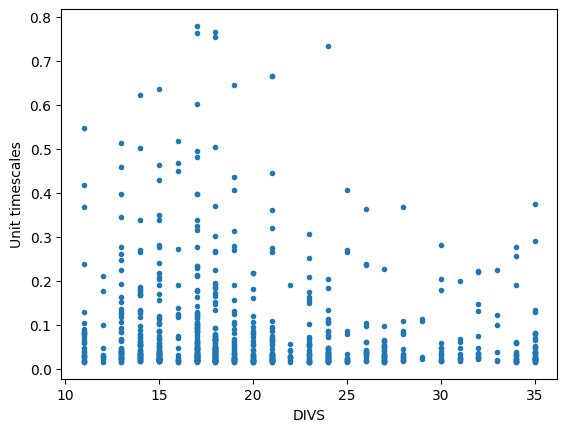

In [38]:
plt.plot(filtered_divs, filtered_taus, '.')
plt.ylabel("Unit timescales")
plt.xlabel("DIVS")

## Hypotheses fitting (for figure 2 for timescale dev paper)

In [39]:
def rsq(xdata, ydata, popt, f):
    
    #residual sum of squares
    residuals = ydata- f(xdata, *popt)
    ss_res = np.sum(residuals**2)
    #total sum of squares
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    
    r_squared = 1 - (ss_res / ss_tot)
    
    return r_squared
    

In [40]:
def f_test(xdata, ydata, model0, model1, popt0, popt1, p0, p1):

    yfit0 = model0(xdata, *popt0)
    yfit1 = model1(xdata, *popt1)

    ssq0 = ((yfit0-ydata)**2).sum()
    ssq1 = ((yfit1-ydata)**2).sum()
    
    param_diff = p1 - p0
    print(param_diff)
    
    if param_diff == 0:
        df_0 = len(xdata) - p0
        df_1 = len(xdata) - p1
        f_ratio = ssq1/ssq0
        p = 1 - ss.f.cdf(f_ratio, df_0, df_1)
    else:
        df = len(xdata) - p1
        print("df", df)
        f_ratio = ((ssq0 - ssq1) / param_diff) / (ssq1 / df)
        p = 1 - ss.f.cdf(f_ratio, param_diff, df)

    return f_ratio, p

In [41]:
# Define the Gaussian function
def gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) 
# Define the sigmoid function
def sigmoid(x, A, B, C, D):
    return A / (1 + np.exp(-C * (x - B))) + D

# Define the horizontal line function (constant)
def horizontal_line(x, A):
    return A

In [71]:
def fit_hyp(divs, taus, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid):
    
    
    # Fit the Gaussian function to your data
    params_gaussian, _ = curve_fit(gaussian, divs, taus, p0=guess_gaussian, bounds=bounds_gaussian, maxfev=50000)

    # Fit the sigmoid function to your data
    params_sigmoid, _ = curve_fit(sigmoid, divs, taus, p0=guess_sigmoid,bounds=bounds_sigmoid, maxfev=50000)

    # Fit the horizontal line to your data
    params_horizontal_line, _ = curve_fit(horizontal_line, divs, taus)


    return params_horizontal_line, params_sigmoid, params_gaussian

In [43]:
def plt_hyp(divs, taus, params_horizontal_line, params_sigmoid, params_gaussian, ylim=None ):
    
    # Create a range of x values for plotting
    x_fit = np.linspace(min(divs), max(divs), 100)

    # Calculate the corresponding y values using the fitted parameters for each function
    y_fit_gaussian = gaussian(x_fit, *params_gaussian)
    y_fit_sigmoid = sigmoid(x_fit, *params_sigmoid)
    y_fit_horizontal_line = horizontal_line(x_fit, params_horizontal_line[0])

    # Plot the data and the fitted functions
    plt.figure(figsize =  (6,5))
    # Create the scatter plot of the data
    plt.plot(divs, taus, '.', color = "dimgrey")
    #plt.ylabel("Log(timescales)", size = 18)
    #plt.xlabel("Days ", size = 18)
    plt.xticks(size = 13)
    plt.yticks(size = 13)

    plt.axhline(y=params_horizontal_line[0], xmin = 0.04, xmax = 0.98, color='#FDAE61', linestyle='-.', linewidth=5,dashes=(5,2))
    plt.plot(x_fit, y_fit_sigmoid, '-.', color='#2D7BB6', linewidth=5, dashes=(4,2))
    plt.plot(x_fit, y_fit_gaussian, '-.',color='#D7191D', linewidth=5, dashes=(2, 2))
    
    if ylim:
        plt.ylim(ylim[0],ylim[1])

    
    """
    days_pn = ['6', '11', '16', '21','26','31']
    
    locs, labels = plt.xticks()
    print(locs)
    labels = days_pn
    plt.xticks(locs[1:-1], labels)"""
    plt.show()

### Linear version

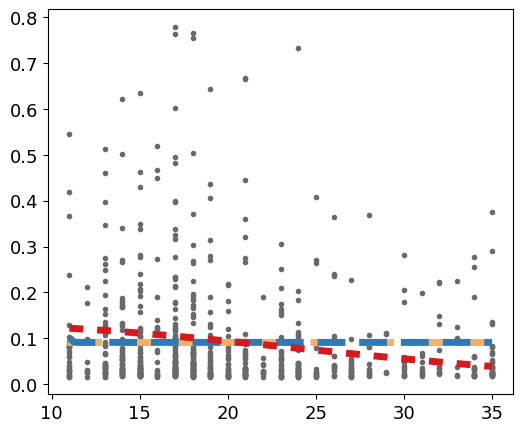

In [44]:
#guess gaussian - [initial_A, initial_mu, initial_sigma]
#bounds gaussian - ([min_A, min_mu, min_sigma], [max_A, max_mu, max_sigma])
#A: Amplitude
#mu: Mean (center)
#sigms: Standard Deviation
    

# Guess and bounds for Gaussian fit
guess_gaussian = [0.4, 17, 5]
bounds_gaussian = ([0.13, 0, 5], [10, 17, 20])

#guess sigmoid - [initial_A, initial_x0, initial_k, initial_b]
#bounds sigmoid  - ([min_A, min_x0, min_k, min_b], [max_A, max_x0, max_k, max_b])
#A: Amplitude
#x0: Midpoint
#k: Slope
#b: Offset

# Guess and bounds for Sigmoid fit
guess_sigmoid = (2.0, 10.0, 1.0, 1.0)
bounds_sigmoid = ([-np.inf, 10, -np.inf, -np.inf], [np.inf, 30, np.inf, np.inf])

params_horizontal_line, params_sigmoid, params_gaussian = fit_hyp(filtered_divs, filtered_taus, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)

#plot
plt_hyp(filtered_divs, filtered_taus, params_horizontal_line, params_sigmoid, params_gaussian, ylim=None )

### Logged version

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


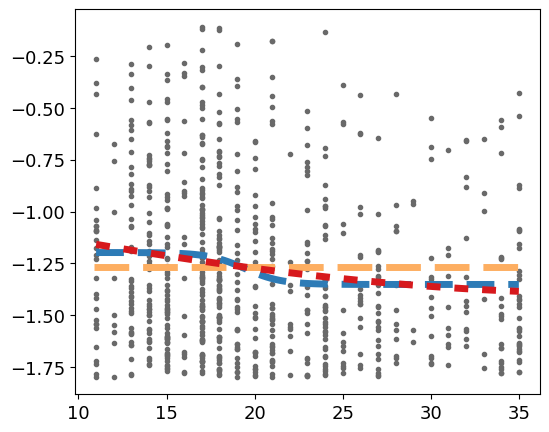

In [45]:
filtered_taus_log = np.log10(filtered_taus)

# Guess and bounds for Gaussian fit
guess_gaussian = [0.6, 15, 0.5
                 ]
bounds_gaussian = ([0.2, 10,0], [0.9,20, 10])
bounds_gaussian = ([-np.inf, -np.inf,-np.inf], [np.inf,np.inf, np.inf])

# Guess and bounds for Sigmoid fit
guess_sigmoid = (0.0, 15.0, 3.0, 1.0)
bounds_sigmoid = ([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])

params_horizontal_line_log, params_sigmoid_log, params_gaussian_log = fit_hyp(filtered_divs, filtered_taus_log, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)

#plot
plt_hyp(filtered_divs, filtered_taus_log, params_horizontal_line_log, params_sigmoid_log, params_gaussian_log, ylim=None )

### Normalized divs linear 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


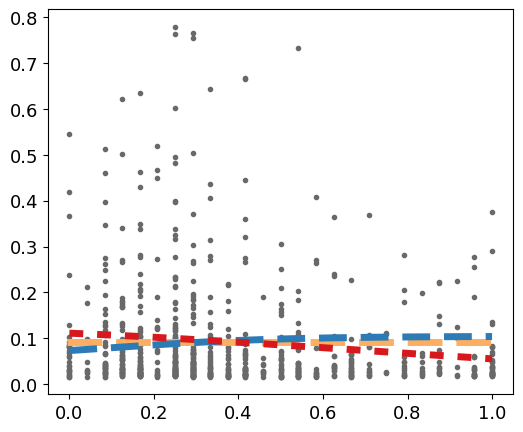

In [46]:

# Normalize the divs data to the range [0, 1]
divs_normalized = (filtered_divs - filtered_divs.min()) / (filtered_divs.max() - filtered_divs.min())

# Guess and bounds for Gaussian fit
guess_gaussian = [0.1, 0.4, 0.25]
bounds_gaussian = ([0.05, 0.2, 0], [10, 0.5, 0.3])
bounds_gaussian = ([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf])
#guess sigmoid - [initial_A, initial_x0, initial_k, initial_b]
#bounds sigmoid  - ([min_A, min_x0, min_k, min_b], [max_A, max_x0, max_k, max_b])
#A: Amplitude
#x0: Midpoint
#k: Slope
#b: Offset

# Guess and bounds for Sigmoid fit
guess_sigmoid = (0.1, 0.2, 6, 0.5)
bounds_sigmoid = ([0.05, 0.1, 5, -np.inf], [np.inf, 0.6, np.inf, np.inf])

params_horizontal_line_norm, params_sigmoid_norm, params_gaussian_norm = fit_hyp(divs_normalized, filtered_taus, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)

#plot
plt_hyp(divs_normalized, filtered_taus, params_horizontal_line_norm, params_sigmoid_norm, params_gaussian_norm, ylim=None )


### Compute rsqs for fits - log version

In [47]:
#get r-squared values

rsqs_rat_h0 = rsq(filtered_divs,  filtered_taus_log, params_horizontal_line_log, horizontal_line) 
rsqs_rat_h1 = rsq(filtered_divs,  filtered_taus_log, params_sigmoid_log, sigmoid) 
rsqs_rat_h2 = rsq(filtered_divs,  filtered_taus_log, params_gaussian_log, gaussian) 

print("rsq rat h0:", rsqs_rat_h0)
print("rsq rat h1:", rsqs_rat_h1)
print("rsq rat h2:", rsqs_rat_h2)

rsq rat h0: 0.0
rsq rat h1: 0.026266140042587205
rsq rat h2: 0.02313426690610565


### f-tests

In [48]:

#f-tests
f_test_h0_h1 = f_test(filtered_divs, filtered_taus_log, horizontal_line, sigmoid,
                      params_horizontal_line_log, params_sigmoid_log, 1, 4)
f_test_h0_h2 = f_test(filtered_divs, filtered_taus_log, horizontal_line, gaussian, 
                      params_horizontal_line_log, params_gaussian_log,1,3)
f_test_h2_h1 = f_test(filtered_divs, filtered_taus_log, gaussian, sigmoid, 
                      params_gaussian_log, params_sigmoid_log,3,4)

print("f_test rat h0 vs h1:", f_test_h0_h1)
print("f_test rat h0 vs h2:", f_test_h0_h2)
print("f_test rat h1 vs h2:", f_test_h2_h1)

3
df 761
2
df 762
1
df 761
f_test rat h0 vs h1: (6.842572149123333, 0.00014928824079496472)
f_test rat h0 vs h2: (9.02289372287671, 0.00013399468370700607)
f_test rat h1 vs h2: (2.447645660557286, 0.11811700783363543)


## Mean analysis

### Get mean days and timescales

In [49]:
def get_mean_std_recday (taus, divs):
    days = sorted(set(divs))
    all_indices = []
    days_taus = []
    mean_taus = []
    std_taus = []

    #get indices for each day

    for d in days:
   
        indices = [i for i, x in enumerate(divs) if x == d]

        
        all_indices.append(indices)
        #get taus for those indices
        day_taus = taus[indices]
        days_taus.append(day_taus)
        #get means and stds
        mean_taus.append(np.mean(day_taus))
        std_taus.append(np.std(day_taus))
        
    return [days, all_indices, days_taus, mean_taus, std_taus]

In [50]:
days, all_indices,days_taus_filt, mean_taus_filt, std_filt = get_mean_std_recday(filtered_taus, filtered_divs)

Text(0.5, 1.0, 'Mean day taus')

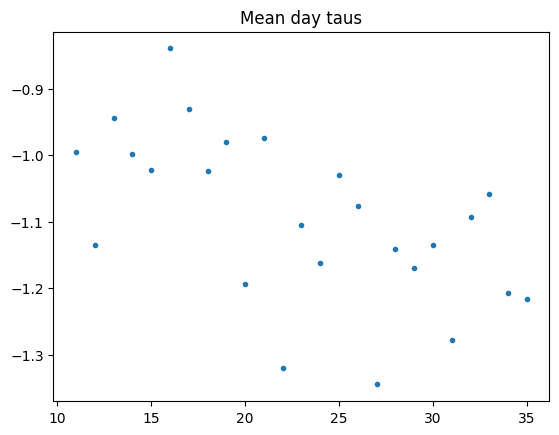

In [51]:
#plot the mean
plt.plot(days, np.log10(mean_taus_filt), '.')
plt.title("Mean day taus")

### Fit the mean 

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


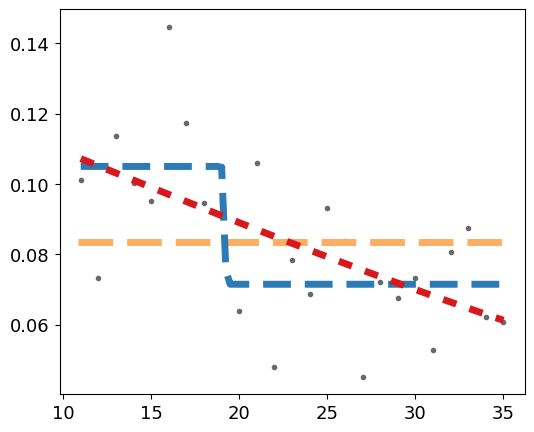

In [52]:
#Linear

# Guess and bounds for Gaussian fit
guess_gaussian = [0.6, 15, 0.5
                 ]
bounds_gaussian = ([0.2, 10,0], [0.9,20, 10])
bounds_gaussian = ([-np.inf, -np.inf,-np.inf], [np.inf,np.inf, np.inf])

# Guess and bounds for Sigmoid fit
guess_sigmoid = (0.0, 15.0, 0.12, 0.06)
bounds_sigmoid = ([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])

params_horizontal_line_mean, params_sigmoid_mean, params_gaussian_mean = fit_hyp(days, mean_taus_filt, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)

#plot
plt_hyp(days,  mean_taus_filt, params_horizontal_line_mean, params_sigmoid_mean, params_gaussian_mean, ylim=None )


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


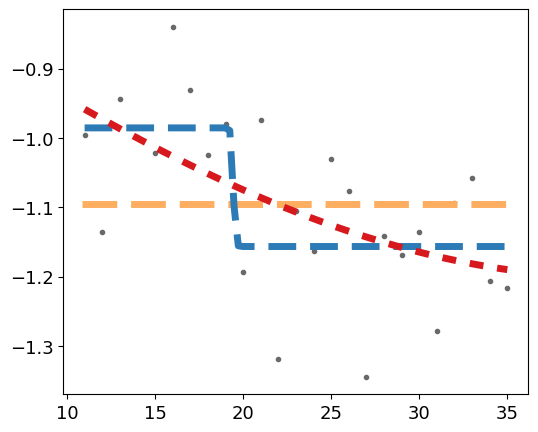

In [53]:
#Log

# Guess and bounds for Gaussian fit
guess_gaussian = [0.6, 15, 0.5
                 ]
bounds_gaussian = ([0.2, 10,0], [0.9,20, 10])
bounds_gaussian = ([-np.inf, -np.inf,-np.inf], [np.inf,np.inf, np.inf])

# Guess and bounds for Sigmoid fit
guess_sigmoid = (0.0, 15.0, -1.0, -1.25)
bounds_sigmoid = ([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])

params_horizontal_line_mean_log, params_sigmoid_mean_log, params_gaussian_mean_log = fit_hyp(days, np.log10(mean_taus_filt), guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)

#plot
plt_hyp(days, np.log10(mean_taus_filt), params_horizontal_line_mean_log, params_sigmoid_mean_log,params_gaussian_mean_log, ylim=None )


### Calculate rsq for mean

In [54]:
#get r-squared values

rsqs_rat_h0 = rsq(days,  np.log10(mean_taus_filt),params_horizontal_line_mean_log, horizontal_line) 
rsqs_rat_h1 = rsq(days,  np.log10(mean_taus_filt),  params_sigmoid_mean_log, sigmoid) 
rsqs_rat_h2 = rsq(days,  np.log10(mean_taus_filt), params_gaussian_mean_log, gaussian) 

print("rsq rat h0:", rsqs_rat_h0)
print("rsq rat h1:", rsqs_rat_h1)
print("rsq rat h2:", rsqs_rat_h2)

rsq rat h0: 0.0
rsq rat h1: 0.447503902215557
rsq rat h2: 0.33310536910029287


### f-tests for mean

In [55]:

#f-tests
f_test_h0_h1 = f_test(days, np.log10(mean_taus_filt), horizontal_line, sigmoid,
                      params_horizontal_line_mean_log, params_sigmoid_mean_log, 1, 4)
f_test_h0_h2 = f_test(days, np.log10(mean_taus_filt), horizontal_line, gaussian, 
                      params_horizontal_line_mean_log, params_gaussian_mean_log,1,3)
f_test_h2_h1 = f_test(days, np.log10(mean_taus_filt), gaussian, sigmoid, 
                      params_gaussian_mean_log, params_sigmoid_mean_log,3,4)

print("f_test rat h0 vs h1:", f_test_h0_h1)
print("f_test rat h0 vs h2:", f_test_h0_h2)
print("f_test rat h1 vs h2:", f_test_h2_h1)

3
df 21
2
df 22
1
df 21
f_test rat h0 vs h1: (5.669772742415023, 0.0052442013998482695)
f_test rat h0 vs h2: (5.494359813873304, 0.011604580103388162)
f_test rat h1 vs h2: (4.34821024990811, 0.04943779249527136)


### Reviewers- number of cells across development decreases

/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


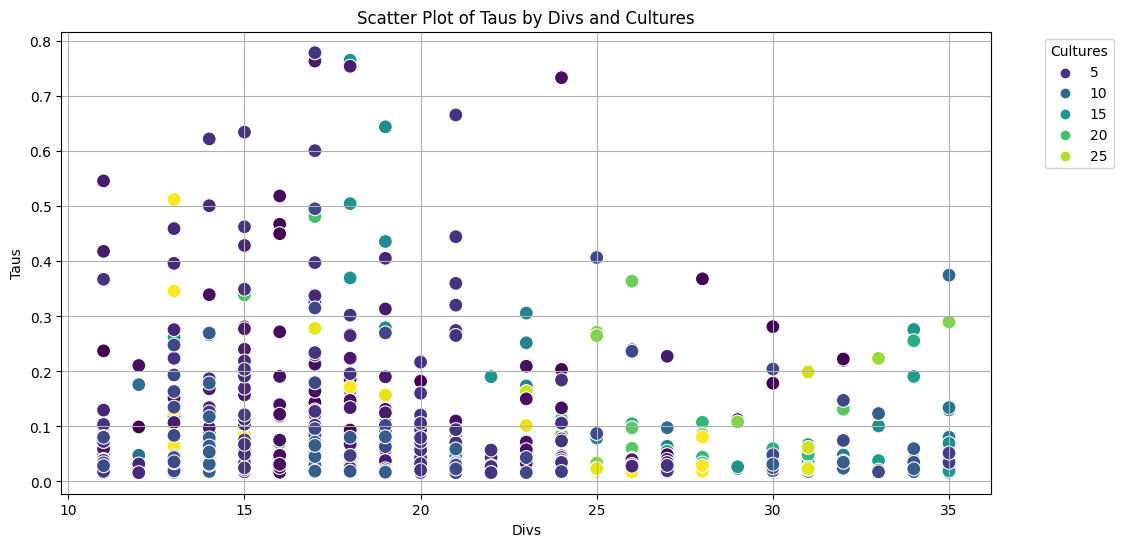

In [56]:
# Create a DataFrame
data = pd.DataFrame({
    'divs': filtered_divs,
    'cultures': filtered_cults,
    'taus': filtered_taus
})

# Create the scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=data, x='divs', y='taus', hue='cultures', palette='viridis', s=100)

# Adding titles and labels
plt.title('Scatter Plot of Taus by Divs and Cultures')
plt.xlabel('Divs')
plt.ylabel('Taus')
plt.legend(title='Cultures', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Display the plot
plt.show()

### Subsample + bootrstrap + refit hypothesis curves 

In [57]:
# Example data: Replace this with your actual data
data = {
    'divs': filtered_divs,  
    'taus': filtered_taus     
}
df = pd.DataFrame(data)

# Function to subsample data
def subsample_data(df, num_samples_per_time_point):
    subsampled_df = df.groupby('divs').apply(lambda x: x.sample(min(len(x), num_samples_per_time_point)))
    subsampled_df.reset_index(drop=True, inplace=True)
    return subsampled_df

# Subsample data to a maximum of 5 samples per time point
subsampled_df = subsample_data(df, 5)
print(subsampled_df)

     divs      taus
0      11  0.103656
1      11  0.028590
2      11  0.015936
3      11  0.237355
4      11  0.084688
..    ...       ...
119    35  0.039300
120    35  0.374955
121    35  0.023312
122    35  0.069461
123    35  0.018730

[124 rows x 2 columns]


/var/folders/rr/tk8wmt7x4xlgzgmcy768y1rm0000gn/T/ipykernel_96139/4239109075.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subsampled_df = df.groupby('divs').apply(lambda x: x.sample(min(len(x), num_samples_per_time_point)))


In [82]:
# Function to bootstrap data
def bootstrap_data(df, num_bootstrap_samples):
    bootstrap_samples = []
    for _ in range(num_bootstrap_samples):
        bootstrap_sample = df.sample(len(df), replace=True)
        bootstrap_samples.append(bootstrap_sample)
    return bootstrap_samples

# Generate bootstrap samples
bootstrap_samples = bootstrap_data(subsampled_df, 50)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


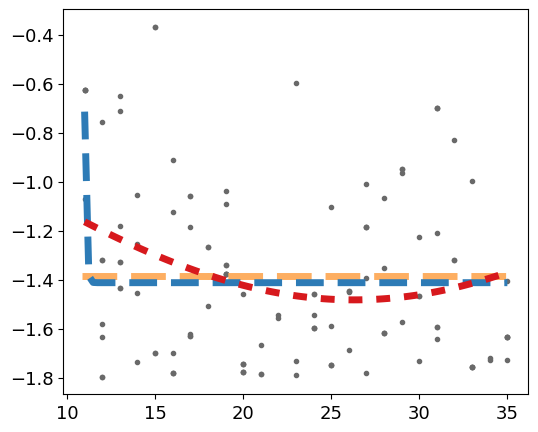

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


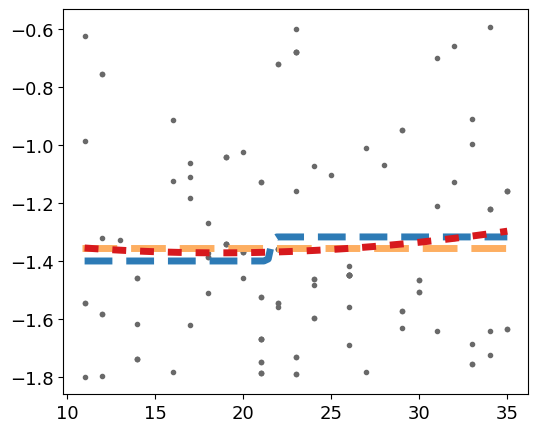

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


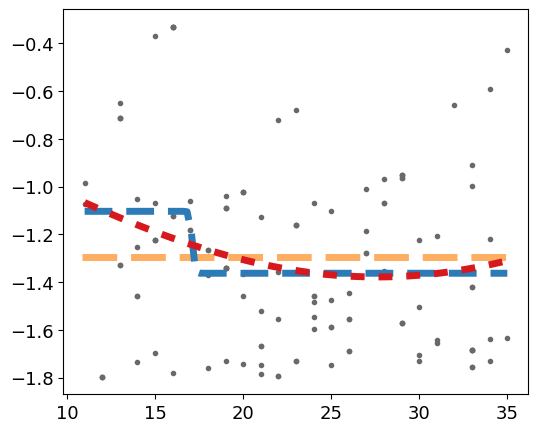

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


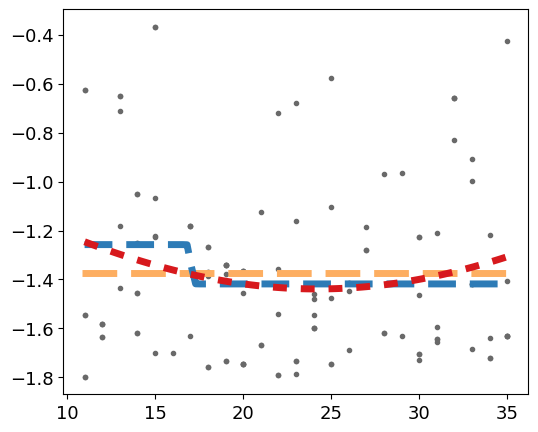

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


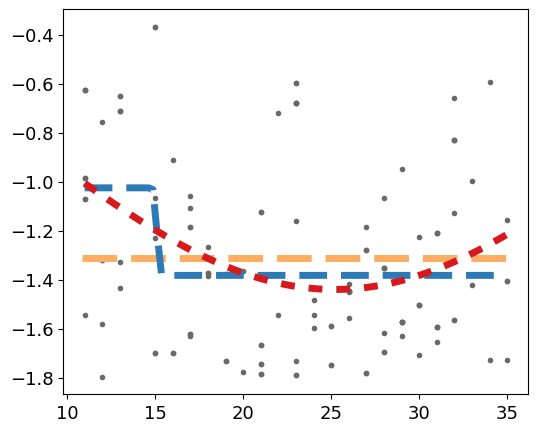

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


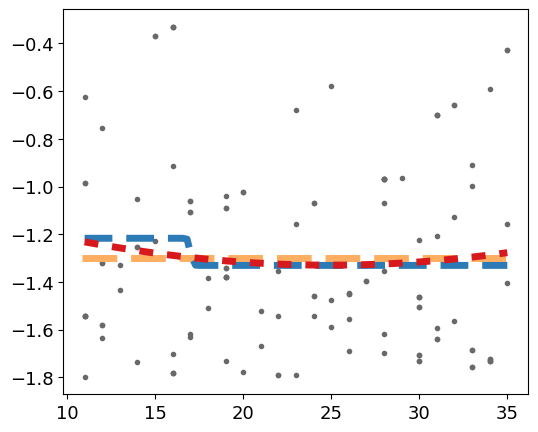

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


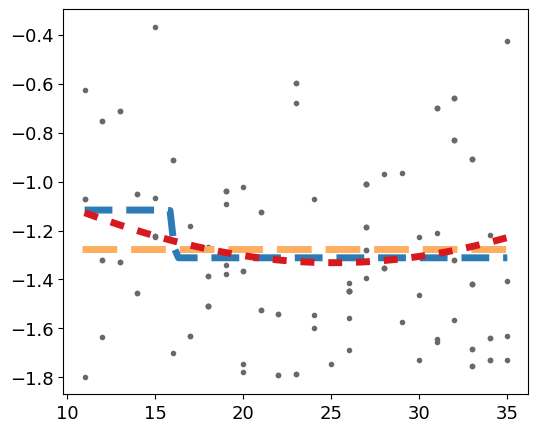

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


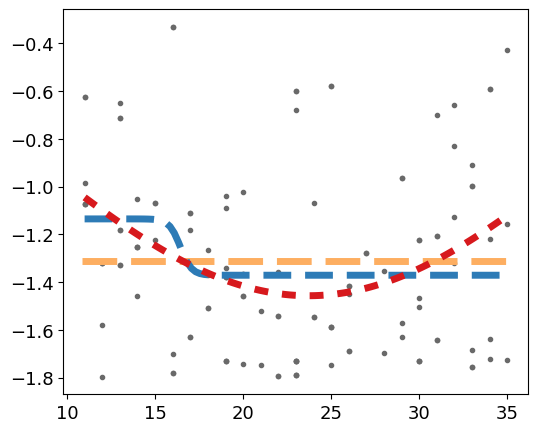

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


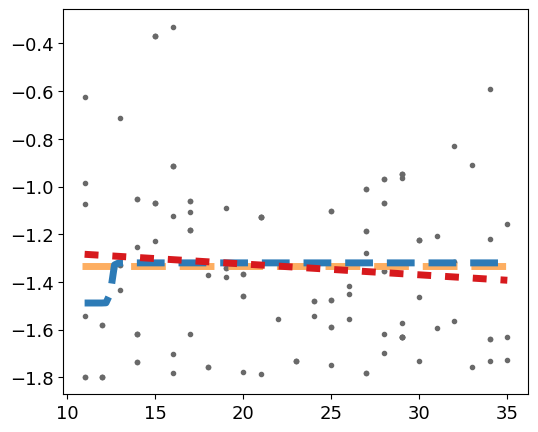

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


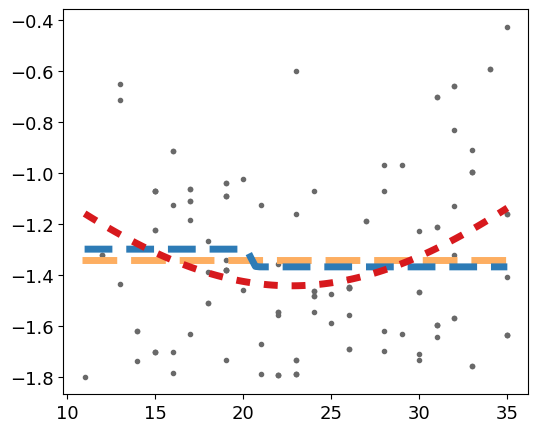

/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


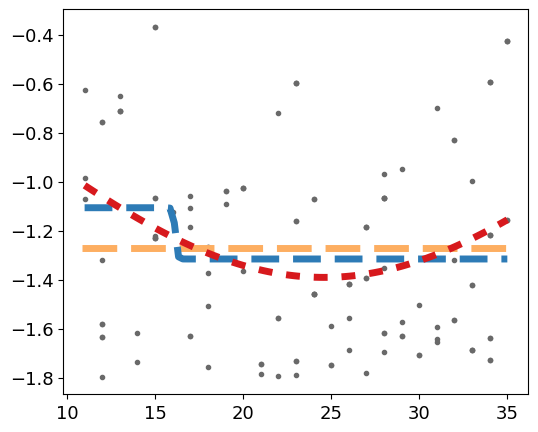

/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


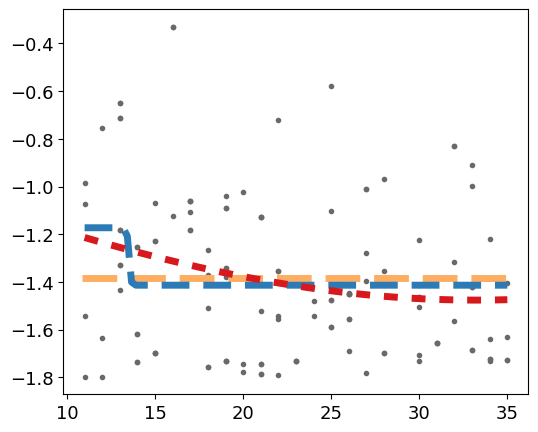

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


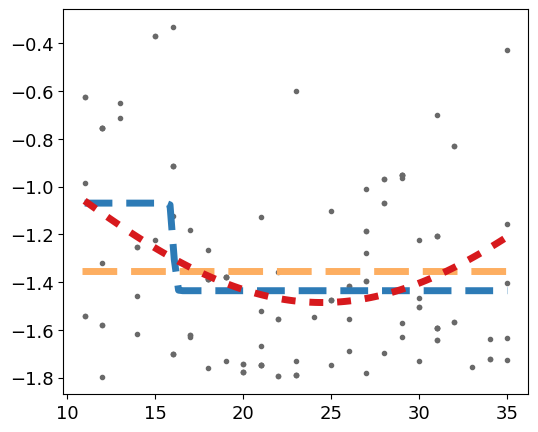

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


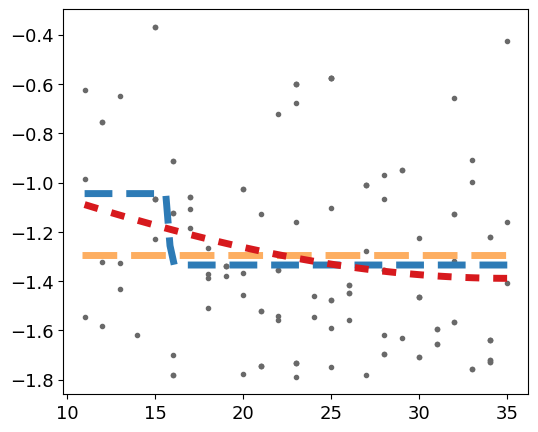

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


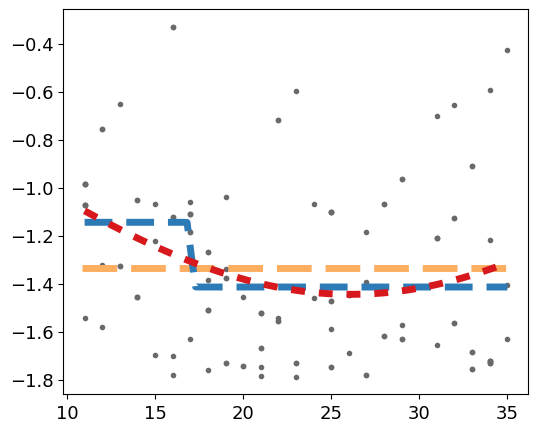

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


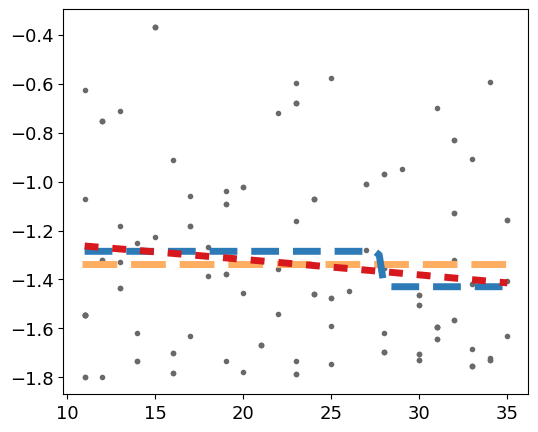

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


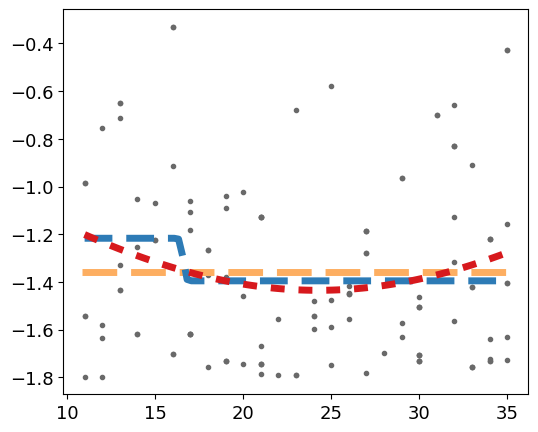

/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


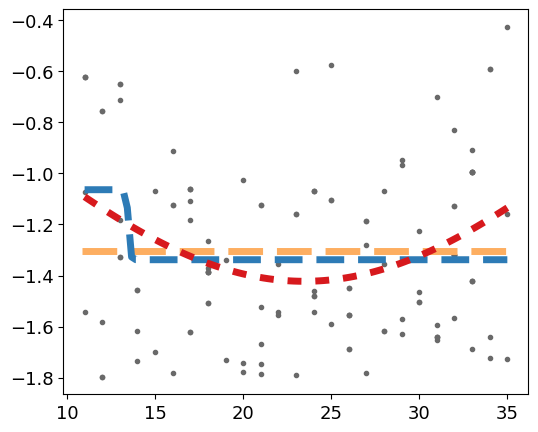

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


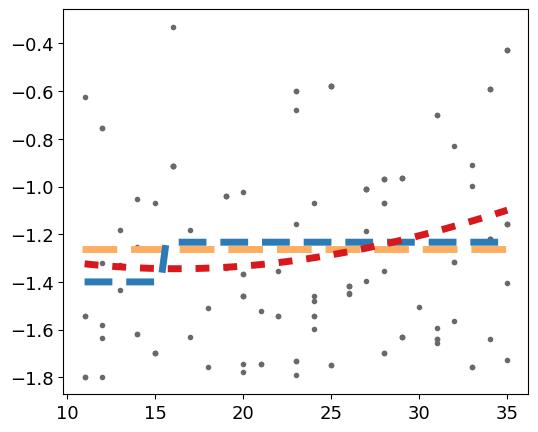

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


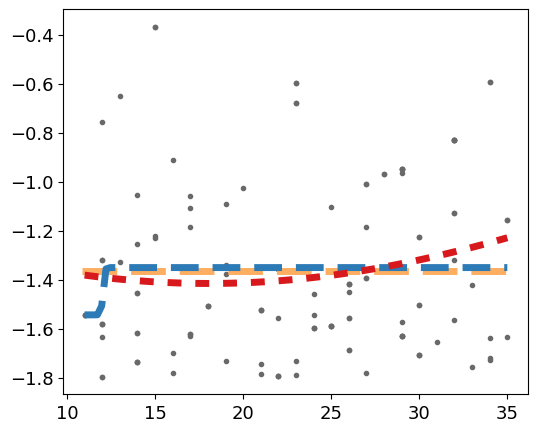

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


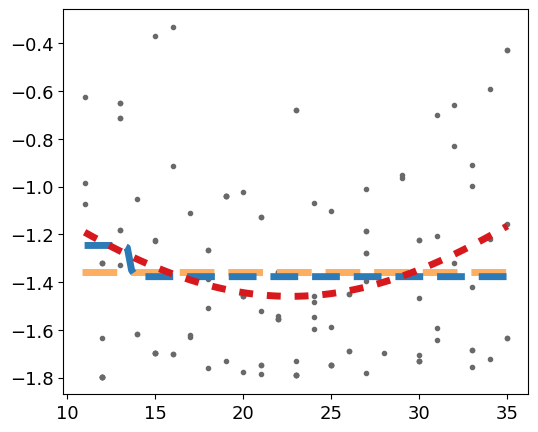

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


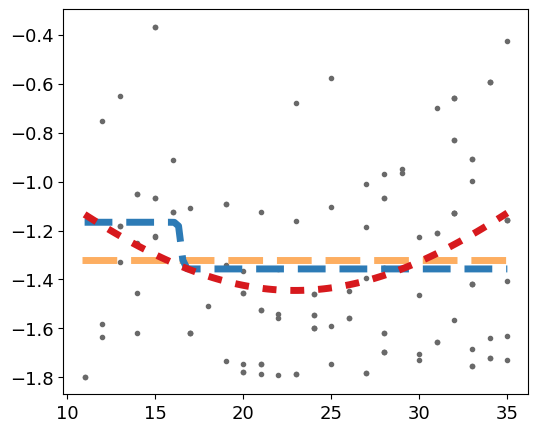

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


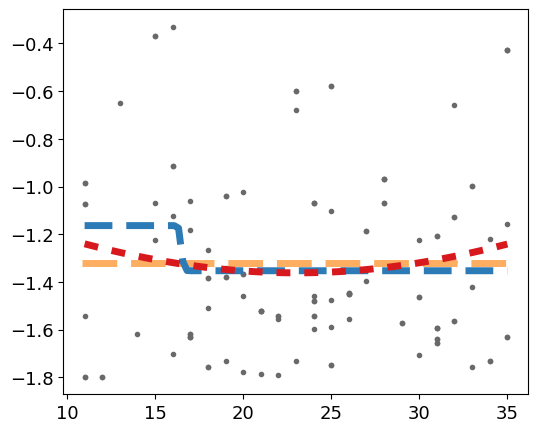

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


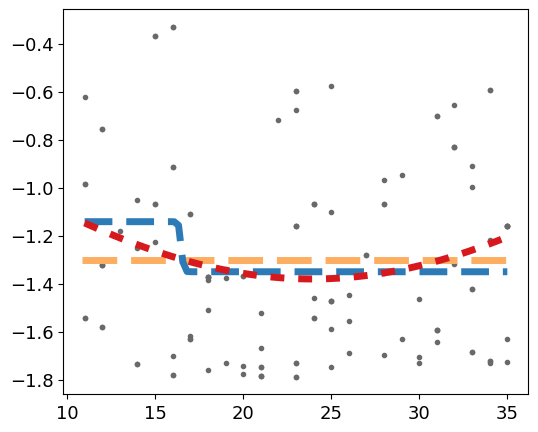

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


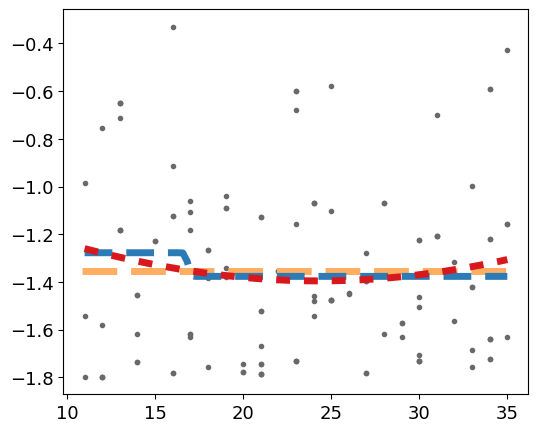

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


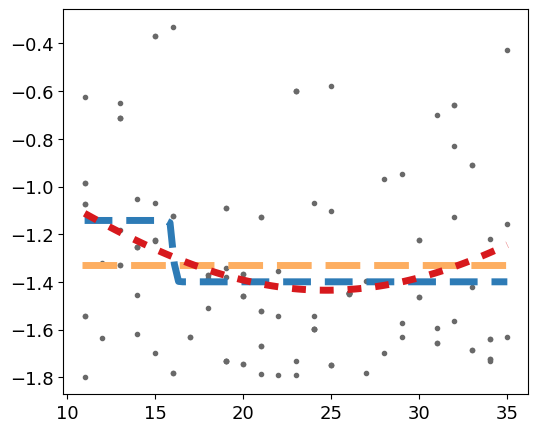

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


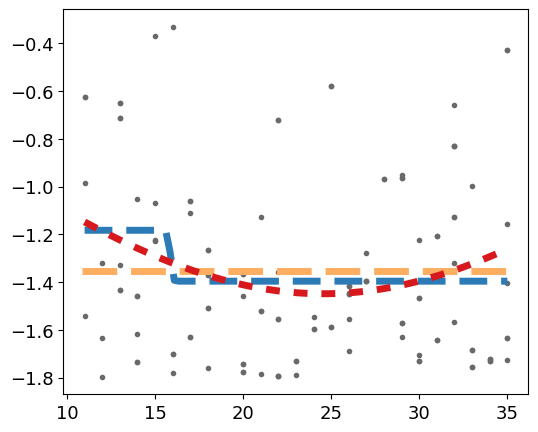

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


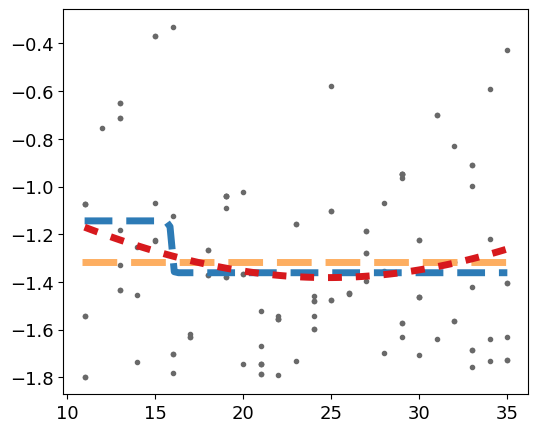

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


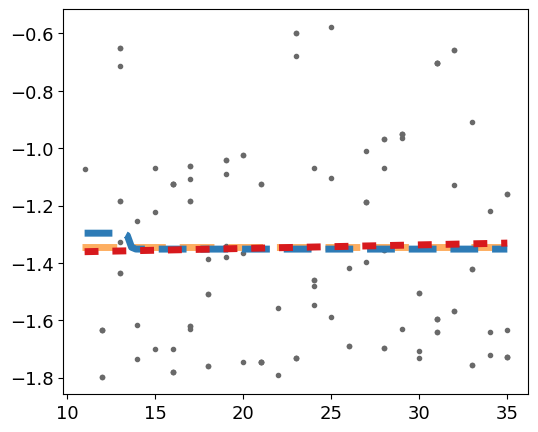

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


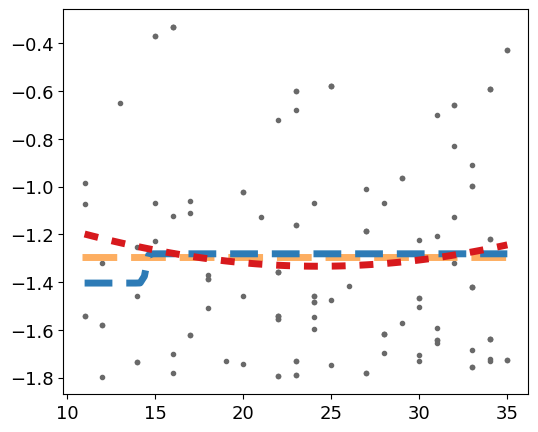

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


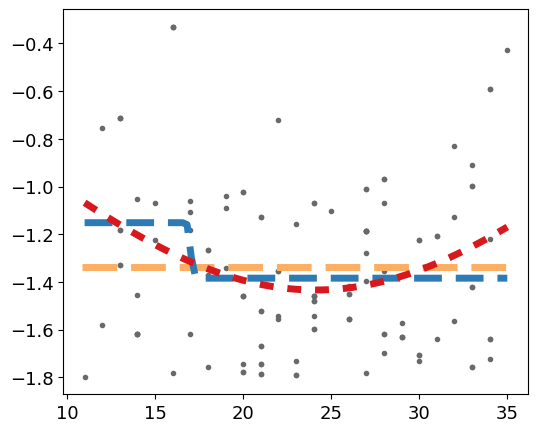

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


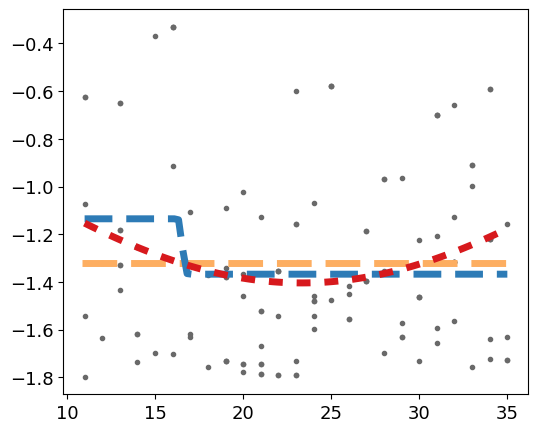

/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


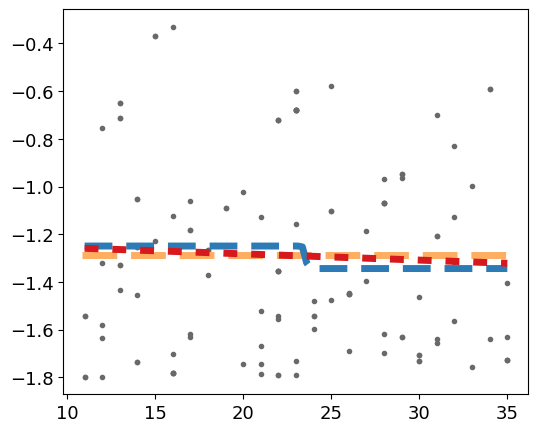

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


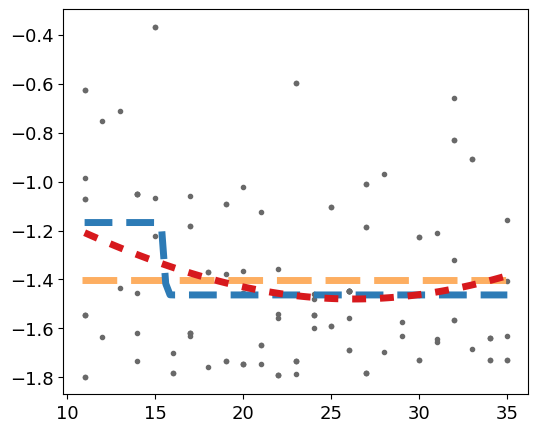

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


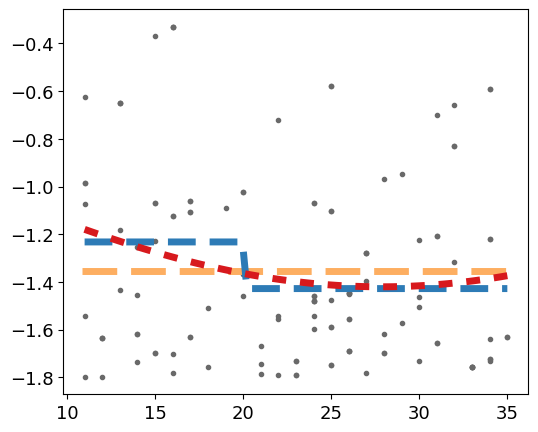

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


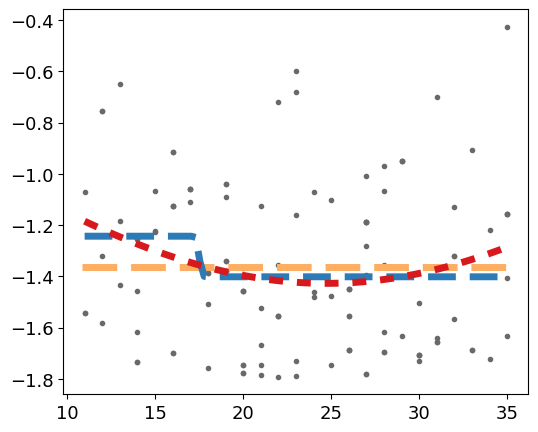

/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


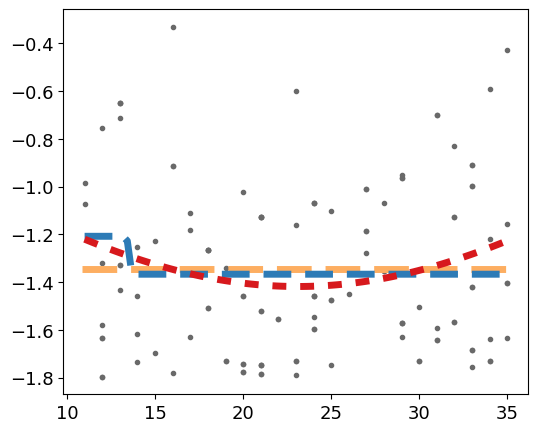

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


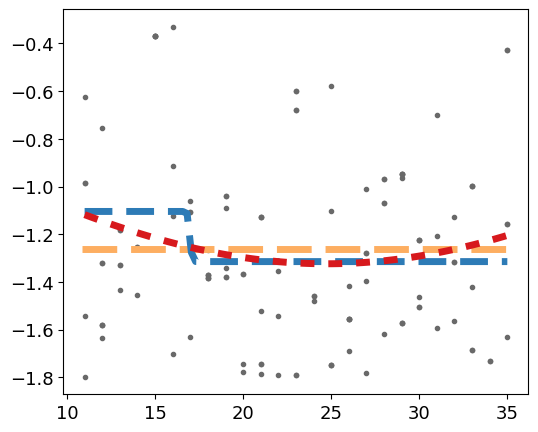

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


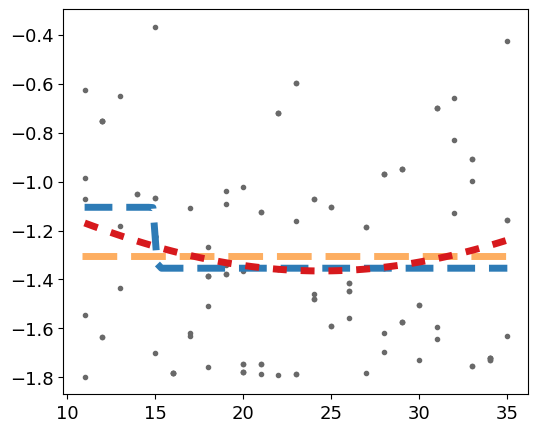

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


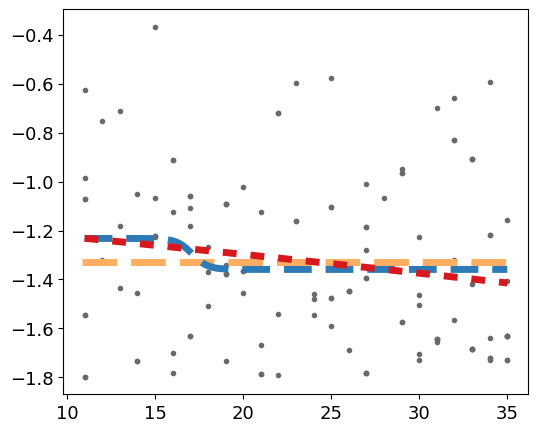

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


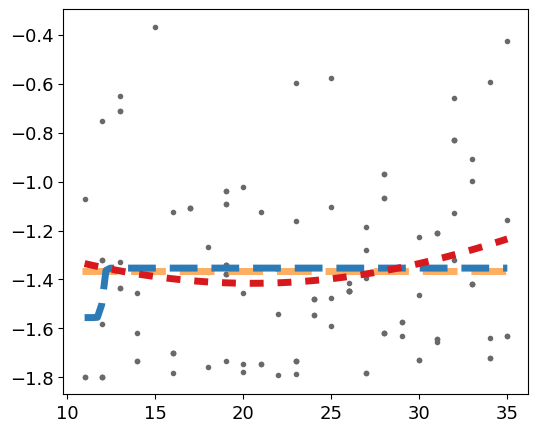

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


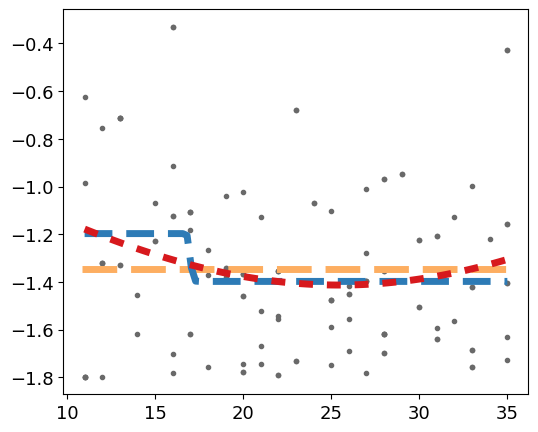

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


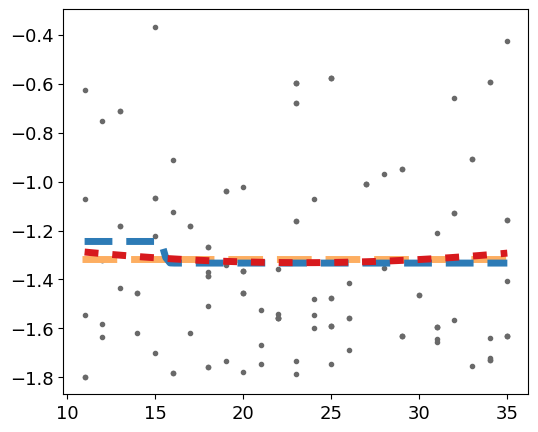

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


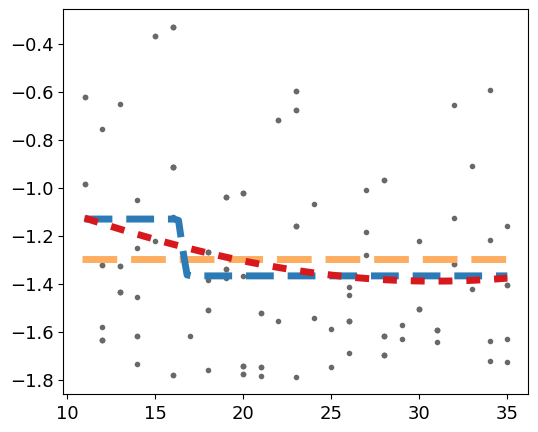

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


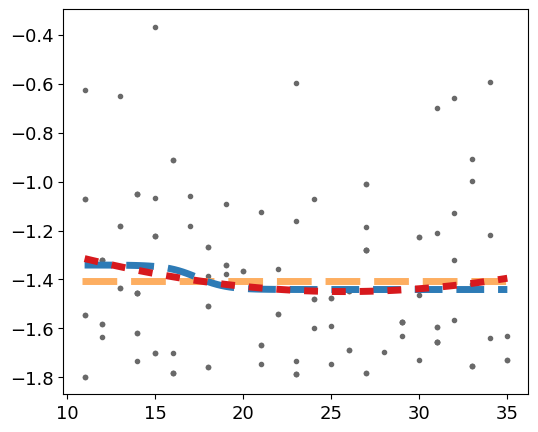

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


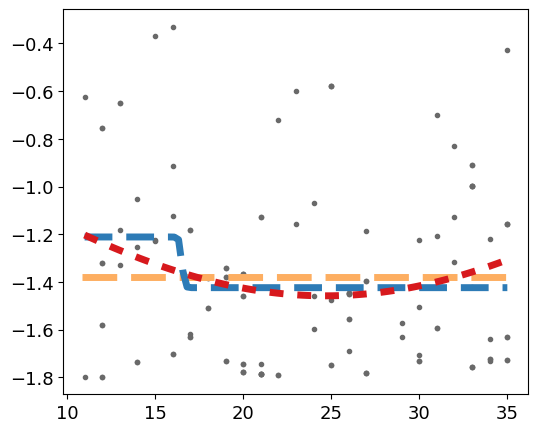

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


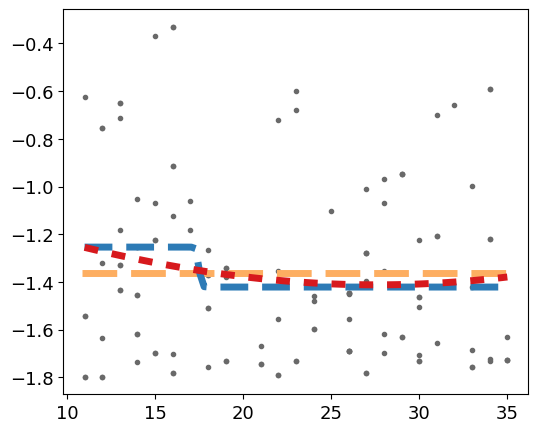

/Users/blancamartin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


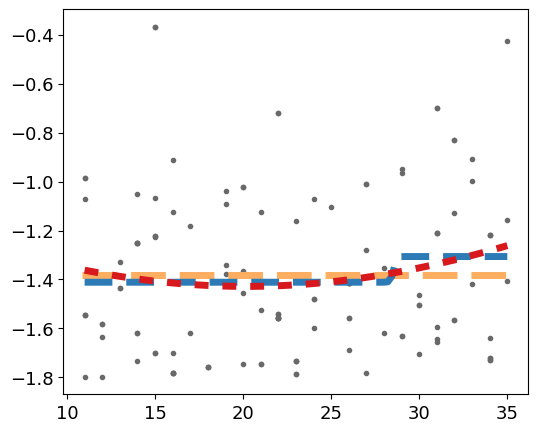

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


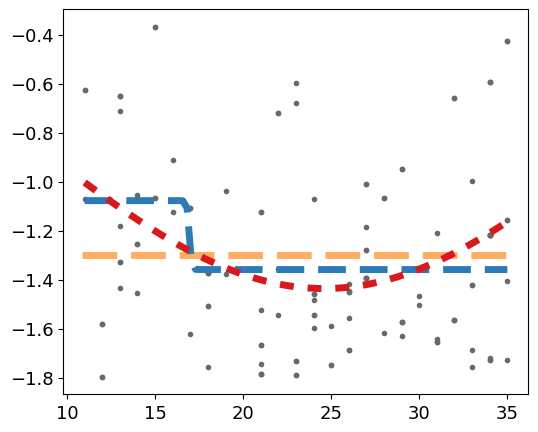

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


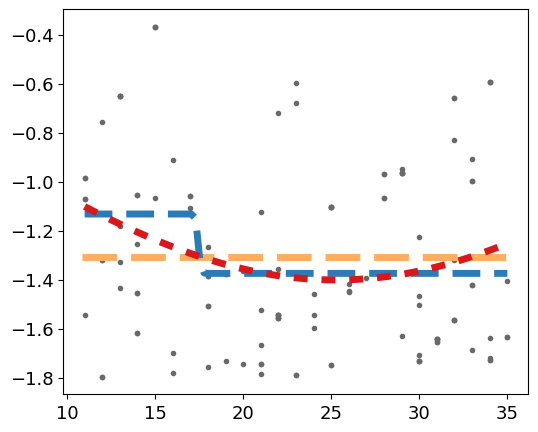

In [83]:
# Fit hypothesis functions to bootstraped samples

#loop through bootstrapped samples 
for i in range(len(bootstrap_samples)):

    filtered_taus_log = np.log10(bootstrap_samples[i]['taus'])
    
    # Guess and bounds for Gaussian fit
    guess_gaussian = [0.6, 15, 0.5
                     ]
    bounds_gaussian = ([0.2, 10,0], [0.9,20, 10])
    bounds_gaussian = ([-np.inf, -np.inf,-np.inf], [np.inf,np.inf, np.inf])
    
    # Guess and bounds for Sigmoid fit
    guess_sigmoid = (0.0, 15.0, 3.0, 1.0)
    bounds_sigmoid = ([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf])
    
    params_horizontal_line_log, params_sigmoid_log, params_gaussian_log = fit_hyp(bootstrap_samples[i]['divs'], filtered_taus_log, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)
    
    #plot
    plt_hyp(bootstrap_samples[i]['divs'], filtered_taus_log, params_horizontal_line_log, params_sigmoid_log, params_gaussian_log, ylim=None )

In [85]:
# Initialize an empty list to store fit results for each bootstrapped sample
fit_results = []

# Loop through bootstrap samples and fit functions
for i, sample in enumerate(bootstrap_samples):
    divs = sample['divs']
    taus = sample['taus']
    
    # Fit functions
    params_horizontal_line, params_sigmoid, params_gaussian = fit_hyp(divs, taus, guess_gaussian, bounds_gaussian, guess_sigmoid, bounds_sigmoid)

     # Append fit results to the list
    fit_results.append((params_horizontal_line, params_sigmoid, params_gaussian))




Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [91]:
def plot_all_hyp(bootstrap_samples, fit_results, num_bootstrap_samples=None, figsize=(10, 6)):
    # Initialize arrays to store upper and lower bounds of confidence intervals
    upper_bounds = []
    lower_bounds = []
    
    # Loop through each fit result
    for fit_params in fit_results:
        params_horizontal_line, params_sigmoid, params_gaussian = fit_params
        
        # Calculate fitted curves for this fit result
        x_fit = np.linspace(min(divs), max(divs), 100)
        y_fit_gaussian = gaussian(x_fit, *params_gaussian)
        y_fit_sigmoid = sigmoid(x_fit, *params_sigmoid)
        y_fit_horizontal_line = horizontal_line(x_fit, *params_horizontal_line)
        
        # Store upper and lower bounds for each fitted curve
        upper_bounds.append(np.maximum.reduce([y_fit_gaussian, y_fit_sigmoid, y_fit_horizontal_line], axis=0))
        lower_bounds.append(np.minimum.reduce([y_fit_gaussian, y_fit_sigmoid, y_fit_horizontal_line], axis=0))
    
    # Calculate mean curve and confidence intervals
    upper_bound = np.percentile(upper_bounds, 97.5, axis=0)
    lower_bound = np.percentile(lower_bounds, 2.5, axis=0)
    mean_curve = np.mean(upper_bounds, axis=0)
    
    # Plot mean curve and confidence intervals
    plt.figure(figsize=figsize)
    plt.plot(x_fit, mean_curve, label='Mean Curve', color='black')
    plt.fill_between(x_fit, lower_bound, upper_bound, color='gray', alpha=0.3, label='95% Confidence Interval')
    plt.xlabel('DIVs')
    plt.ylabel('Taus')
    plt.title('Bootstrapped Results')
    plt.legend()
    plt.show()




In [92]:
#Plot results 
plot_all_hyp(bootstrap_samples, fit_results)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.